In [6]:
import csv
import pickle
import itertools
from collections import Counter
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import book_code.dzcnapy_plotlib as dzcnapy
import os


### Data source
https://www.kaggle.com/code/residentmario/gotta-get-the-papers-get-the-papers/notebook

For the construction, let’s select only the edges that refer to
the “beneficiary-of” relationship (there are 19,194 edges labeled Beneficiary of and
beneficiary of). We will go through the files Entities.csv, Officers.csv, and
Intermediaries.csv in search of incident nodes. For each node, we will store its
name, type, and a three-letter country code. The first code block imports all the
necessary modules and defines the constants.

In [2]:
data_dir = './data/panama/'
EDGES = "beneficiary"
NODES = (("Entities.csv", "jurisdiction", "name"),
("Officers.csv", "country_codes", "name"),
("Intermediaries.csv", "country_codes", "name"))

Now, it’s time to build a network graph. Start with an empty nx.Graph object and
read all rows from all_edges.csv with a CSV dictionary reader. (But keep only
those future edges that are marked as beneficiary of in any character case.)

In [4]:
panama = nx.Graph()
with open("./data/panama/all_edges.csv") as infile:
    data = csv.DictReader(infile)
    panama.add_edges_from((link["node_1"], link["node_2"]) \
        for link in data if link["rel_type"].lower().startswith(EDGES))

Read each of the files with a CSV dictionary reader
and extract and collect the desired attributes. Note that there is no need to
process rows that do not match any existing node (because your network does
not include all nodes and edges) and add any nodes to the graph (because they
have been already added by way of the incident edges). When done, update the
node attributes country and kind, and relabel the nodes to match persons and
organizations names.

In [8]:
nodes = set(panama.nodes())
relabel = {}

for f, cc, name in NODES:
    with open(os.path.join(data_dir,f),encoding="utf8") as infile:
        kind = f.split(".")[0]
        data = csv.DictReader(infile)
        names_countries = {node["node_id"] :
                           (node[name].strip().upper(), node[cc])
                           for node in data
                           if node["node_id"] in nodes}
    names =     {nid: values[0] for nid, values in names_countries.items()}
    countries = {nid: values[1] for nid, values in names_countries.items()}
    kinds =     {nid: kind      for nid, _      in names_countries.items()}
    nx.set_node_attributes(panama, countries, "country")
    nx.set_node_attributes(panama, kinds, "kind")
    relabel.update(names)

In [9]:
nx.relabel_nodes(panama, relabel, copy=False)

Finally, remove the phony node ISSUES OF: (there is no explanation of its purpose
in the dataset documentation) and a mysterious node with no name at all.

In [10]:
if "ISSUES OF:" in panama:
    panama.remove_node("ISSUES OF:")

In [11]:
if "" in panama:
    panama.remove_node("")

print(nx.number_of_nodes(panama), nx.number_of_edges(panama))

27926 19135


In [12]:
import pickle

As it turns out, the newly minted network consists of several thousand
disconnected fragments called components, most of which have only two to
three nodes.

The choice of numbers is
somewhat arbitrary; you may want to play with them to wipe off as much of the
“network dust” as you wish. In fact, you are under no obligation to do any
filtering at all—or you can select only the biggest component.

In [24]:
p1= (panama.subgraph(c) for c in nx.connected_components(panama))

In [25]:
components = [p.nodes() for p in p1 \
                        if nx.number_of_nodes(p) >= 20 \
                            or nx.number_of_edges(p) >= 20]
panama0 = panama.subgraph(itertools.chain.from_iterable(components))

print(nx.number_of_nodes(panama0), nx.number_of_edges(panama0))

with open("./data/panama/panama-beneficiary.pickle", "wb") as outfile:
    pickle.dump(panama0, outfile)

1393 1926


#### Draw the Network

You can see with a naked eye that some components have an Officer in
the center, surrounded by Entities; in some other components, conversely,
Officers surround an Entity in the center.

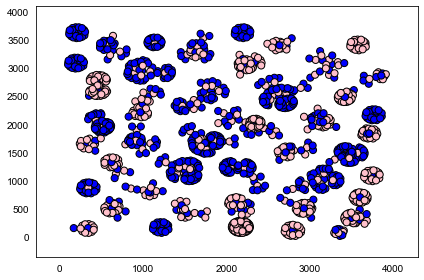

In [27]:
cdict = {"Entities": "pink", "Officers": "blue",
"Intermediaries" : "green"}
c = [cdict[panama0.nodes[n]["kind"]] for n in panama0]
dzcnapy.small_attrs["node_color"] = c
pos = graphviz_layout(panama0)
nx.draw_networkx(panama0, pos=pos, with_labels=False, **dzcnapy.small_attrs)
dzcnapy.set_extent(pos, plt)
dzcnapy.plot("panama0")

#### Analyze the Network
Out of so many ways to analyze a network, let’s focus on degree and
assortativity analysis. All network nodes have two attributes: kind (with three
possible values Entities, Officers, or Intermediaries) and country. Let’s have a look at
each of the assortativities, both directly and through the attribute mixing matrix
(only for the kind).

In [29]:
nx.attribute_assortativity_coefficient(panama0, "kind")

-0.9896603076687625

The network is almost perfectly dissortative with respect to the node kinds. The
matrix explains the details: an Entity node (column 0) is almost always
connected to an Officer node (column 1) because Officers are “beneficiaries-of”
Entities. Very few Entities are linked to each other through Intermediaries.

In [30]:
nx.attribute_mixing_matrix(panama0, "kind", mapping={"Entities": 0, "Officers": 1,
                                    "Intermediaries" : 2})


array([[0.00000000e+00, 4.97403946e-01, 2.59605400e-04],
       [4.97403946e-01, 4.67289720e-03, 0.00000000e+00],
       [2.59605400e-04, 0.00000000e+00, 0.00000000e+00]])

In [31]:
nx.attribute_assortativity_coefficient(panama0, "country")


-0.1811504399378761

Below number in the output is the degree assortativity coefficient. It is
negative, suggesting that the nodes with a higher degree are surrounded, on
average, by nodes with a smaller degree, and the other way around.

In [32]:
nx.degree_assortativity_coefficient(panama0)

-0.3971707340367028

An essential output of complex network analysis is a node degree distribution.
According to Barabási and Albert [BA99], if a network is a result of preferential
attachment, then the degrees d in the network are distributed by the power law:
p(d)=d^(-a). The converse, in general, is not true. (See a brief overviewhere and more
in What Makes Components Giant?.) If you apply log to the equation, you will
get a linear dependency: 

log(p(d))=-a log(d).

In [39]:
deg = nx.degree(panama0)
x, y = zip(*Counter(deg).items())
# print(x)
# print(y)

One peculiarity of a power law distribution is its “long tail” that, at least
theoretically, tolerates nodes with arbitrary high degrees, limited only by the
total graph size. Your degree distribution has a long tail, too. So, who are they,
the nodes at the tail? Let’s run the final lines of the analysis script that reports
the top ten nodes with the highest degree, nicely formatted.

Four of the tail nodes are Officers; the other five are Entities. The Intermediaries
node did not make it to the top list.

In [44]:
top10 = sorted([(n, panama0.nodes[n]["kind"], v) for n, v in deg],
                            key=lambda x: x[2], reverse=True)[:10]
print("\n".join(["{} ({}): {}".format(*t) for t in top10]))

HELITING S.A. (Officers): 80
T.K.B.K. INTERNATIONAL TRUST (Entities): 39
WORLDWIDE COM-NET INTERNATIONAL TRUST (Entities): 37
THE CLAUDIUS TRUST (Entities): 36
GUANGZHOU CONSTRUCTION & DEVELOPMENT HOLDINGS (CHINA)LIMITED (Officers): 29
ISLANDS INTERNATIONAL TRUST (Entities): 27
RICARDO CAMPOLLO CODINA (Officers): 27
ZEN TRUST (Entities): 26
MR. OLEKSII MYKOLAYOVYCH AZAROV (Officers): 26
FRIENDS OF ASSISI TRUST (Entities): 26


#### Build a “Panama” Network with Pandas

In [47]:
import networkx as nx
import pandas as pd
import numpy as np
# Read the edge list and convert it to a network
edges = pd.read_csv("./data/panama/all_edges.csv")
edges = edges[edges["rel_type"] != "registered address"]
F = nx.from_pandas_edgelist(edges, "node_1", "node_2")

c:\Users\ramsi\anaconda3\envs\graph_env\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
# nx.draw(F)


In [50]:
officers = pd.read_csv("./data/panama/Officers.csv", index_col="node_id")
intermediaries = pd.read_csv("./data/panama/Intermediaries.csv", index_col="node_id")
entities = pd.read_csv("./data/panama/Entities.csv", index_col="node_id")

c:\Users\ramsi\anaconda3\envs\graph_env\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (1,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\Users\ramsi\anaconda3\envs\graph_env\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (1,2,5,6,9,10,11,12,13,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
# Combine the node lists into one dataframe
officers["type"] = "officer"
intermediaries["type"] = "intermediary"
entities["type"] = "entity"
all_nodes = pd.concat([officers, intermediaries, entities])

Just like any other real-life data, the “Panama papers” dataset is “dirty”: it has
duplicates, omissions, typos, and so on. With the following code fragment, you
can partially unify the duplicated names by removing all leading and trailing
whitespaces, merging all inner whitespaces, converting all characters to the
uppercase, converting LIMITED to LTD, and removing some honorifics.

In [52]:
# Do some cleanup of names
all_nodes["name"] = all_nodes["name"].str.upper().str.strip()
# Ensure that all "Bearers" do not become a single node
all_nodes["name"].replace( to_replace=[r"MRS?\.\s+", r"\.", r"\s+", "LIMITED", "THE BEARER",
                            "BEARER", "BEARER 1", "EL PORTADOR", "AL PORTADOR"],
                                value=["", "", " ", "LTD", np.nan, np.nan, np.nan, np.nan, np.nan],
                                    inplace=True, regex=True)

A lot of “Panama” officials go under the nicknames “THE BEARER” and “EL
PORTADOR.” If left unchanged, they may be later lumped into a single network
node. Rename them to a NumPy value np.nan to keep them anonymous but
distinct.

In reality, some nodes have more than one country code, in which case the codes
are separated by a semicolon. Can you modify the code to select the nodes that
are associated with Central Asia through at least one of their country codes?
What you will do next is essentially construct a joint ego network of the seed
nodes expanding two hops away from the seeds. The function
nx.single_source_shortest_path_length(F,seed,cutoff=None) computes the shortest paths
from the node seed to all reachable nodes that are cutoff hops away and closer.

In [65]:
CCODES = "UZB", "TKM", "KAZ", "KGZ", "TJK"
seeds = all_nodes[all_nodes["country_codes"].isin(CCODES)].index
nodes_of_interest = set.union(*[\
                set(nx.single_source_shortest_path_length(F
                                        , seed, cutoff=2).keys()) for seed in seeds])

In [61]:
# Extract the subgraph and relabel it
ego = nx.subgraph(F, nodes_of_interest)

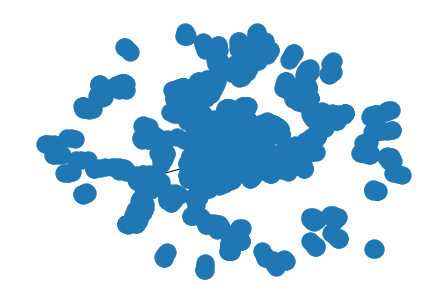

In [66]:
nx.draw(ego)

In [90]:
# nodes = all_nodes[list(nodes_of_interest)]
# nodes = nodes[~nodes.index.duplicated()]
# nodes.head()

In [ ]:
nx.set_node_attributes(ego, "cc", nodes["country_codes"])
valid_names = nodes[nodes["name"].notnull()]["name"].to_dict()
nx.relabel_nodes(ego, valid_names, copy=False)
# Save and proceed to Gephi
with open("./data/panama/panama-ca.graphml", "wb") as ofile:
    nx.write_graphml(ego, ofile)